# Brain Tumor Images Classifier

## Setup environment

In [4]:
!pip install livelossplot imutils

In [5]:
# Connect to google colab
import os

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  try:
    drive.mount("/content/drive",force_remount = True)
    os.chdir("/content/drive/MyDrive/Rootcode_Datathon")
  except:
    print("Mounting of Google drive not possible")
    print("Locally running on drive: " + str(os.getcwd()))

  else:
    print("Colab running on drive: " + str(os.getcwd()))

Mounted at /content/drive
Colab running on drive: /content/drive/MyDrive/Rootcode_Datathon


In [6]:
# IMPORT LIBRARIES

import tempfile

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms as T
import imutils
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from tqdm import tqdm

from src.helpers import get_data_location, compute_mean_and_std

from tqdm import tqdm
import math
from pathlib import Path

In [63]:
# Install requirements - run this if you are running locally
# !pip install -r requirements.txt | grep -v "already satisfied"

In [7]:
example_image_path = os.getcwd() + "/brain_tumor_dataset/no_tumor/nt_img (471).jpg"
example_image = Image.open(example_image_path)
example_image.show()

There's a substanial amount of useless black area in the image.Therefore we have to remove them.

* We have used the `crop_brain_image' class method to return an image after removing useless blackarea.

In [8]:
class CropBrainImage(object):
    def __init__(self, plot=False):
        self.plot = plot

    def __call__(self, img):
        # Convert PIL image to OpenCV format
        image = np.array(img)

        # Apply the cropping function
        image_cropped = self.crop_brain_image(image)

        # Convert back to PIL image
        cropped_pil = Image.fromarray(image_cropped)

        if self.plot:
            self.plot_images(image, image_cropped)

        return cropped_pil

    def crop_brain_image(self, image):
        # The original crop_brain_image function
        # load the image, convert it to grayscale, and blur it slightly
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions + dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(
            thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop the brain out of the original image using the four extreme points
        image_cropped = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

        # Additional feature to plot out and compare the cropped version
        if self.plot == True:
            plt.figure()

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False,
                            right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            plt.title('Original Image')

            # Cropped image
            plt.subplot(1, 2, 2)
            plt.imshow(image_cropped)
            plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False,
                            right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            plt.title('Cropped Image')
            plt.show()

        return image_cropped


In [9]:
# Set the dataset directory path
data_dir = os.getcwd() + "/brain_tumor_dataset"

In [32]:
def get_data_loaders(
    batch_size: int = 32, valid_size: float = 0.15, num_workers: int = 0, limit: int = -1
):
    """
    Create and returns the train_one_epoch, validation and test data loaders.

    :param batch_size: size of the mini-batches
    :param valid_size: fraction of the dataset to use for validation. For example 0.2
                       means that 15% of the dataset will be used for validation
    :param num_workers: number of workers to use in the data loaders. Use -1 to mean
                        "use all my cores"
    :param limit: maximum number of data points to consider
    :return a dictionary with 3 keys: 'train_one_epoch', 'valid' and 'test' containing respectively the
            train_one_epoch, validation and test data loaders
    """

    if num_workers == -1:
        # Use all cores
        num_workers = multiprocessing.cpu_count()

    # We will fill this up later
    data_loaders = {"train": None, "valid": None, "test": None}

    base_path = Path(get_data_location())

    # Compute mean and std of the dataset
    mean, std = compute_mean_and_std()
    print(f"Dataset mean: {mean}, std: {std}")


    # create 3 sets of data transforms: one for the training dataset,
    # containing data augmentation, one for the validation dataset
    # (without data augmentation) and one for the test set (again
    # without augmentation)
    # HINT: resize the image to 256 first, then crop them to 224, then add the
    # appropriate transforms for that step
    data_transforms = {
        "train": transforms.Compose([
            CropBrainImage(plot=False),       # Apply custom cropping first
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(
                brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.ToTensor()]
        ),
        "valid": transforms.Compose([

            CropBrainImage(plot=False),       # Apply custom cropping first
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()]
        ),
        "test": transforms.Compose([

            CropBrainImage(plot=False),       # Apply custom cropping first
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()]
        ),
    }

    # Create train and validation datasets
    train_data = datasets.ImageFolder(
        root=data_dir, transform=data_transforms["train"]
    )

    # Compute the total number of data points and the split sizes
    n_tot = len(train_data)
    split_train = int((1-2*valid_size) * n_tot)
    split_valid = int(valid_size * n_tot)

    # Define indices for train, validation, and test splits
    indices = torch.randperm(n_tot)

    # If requested, limit the number of data points to consider
    if limit > 0:
        indices = indices[:limit]
        n_tot = limit
        split_train = min(split_train, n_tot)
        split_valid = min(split_valid, n_tot)

    train_idx = indices[:split_train]
    valid_idx = indices[split_train:split_train + split_valid]
    test_idx = indices[split_train + split_valid:]

    # Define samplers for train, validation, and test sets
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create DataLoader instances
    data_loaders["train"] = DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )
    data_loaders["valid"] = DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )
    data_loaders["test"] = DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=test_sampler,
        num_workers=num_workers,
    )

    return data_loaders

In [11]:
# function to return the original image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    return ax

In [12]:
# function for training one epoch
def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs one train_one_epoch epoch
    """

    if torch.cuda.is_available():
        # transfer the model to the GPU
        model.cuda()

    # set the model to training mode
    model.train()

    train_loss = 0.0

    for batch_idx, (data, target) in tqdm(
        enumerate(train_dataloader),
        desc="Training",
        total=len(train_dataloader),
        leave=True,
        ncols=80,
    ):
        # move data to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output  = model(data)
        # calculate the loss
        loss_value = loss(output,target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss_value.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        # update average training loss
        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )

    return train_loss

In [13]:
# function for validating one epoch
def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """

    with torch.no_grad():

        # set the model to evaluation mode
        if torch.cuda.is_available():
            model.cuda()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(valid_dataloader),
            desc="Validating",
            total=len(valid_dataloader),
            leave=True,
            ncols=80,
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # orward pass: compute predicted outputs by passing inputs to the model
            output  = model(data)
            # 2. calculate the loss
            loss_value  = loss(output,target)

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

    return valid_loss

In [14]:
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])


In [15]:
# function for optimizing the model
def optimize(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a
    # plateau - docs below
    # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")

            # Save the weights to save_path
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        scheduler.step()

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

In [22]:
# function for testing the model
def one_test_epoch(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        if torch.cuda.is_available():
            model = model.cuda()

        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            logits  =model(data)
            # calculate the loss
            loss_value  =loss(logits,target)

            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

            # convert logits to predicted class
            # the predicted class is the index of the max of the logits
            pred  = logits.data.max(1,keepdim=True)[1]

            # compare predictions to true label
            correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
            total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return test_loss

_____

In [23]:
def visualize_one_batch(data_loaders, type = "train", max_n: int = 5 ):
    """
    Visualize one batch of data.

    :param data_loaders: dictionary containing data loaders
    :param type : "train" default value
    :param max_n: maximum number of images to show
    :return: None
    """

    # obtain one batch of training images
    # First obtain an iterator from the train dataloader
    dataiter = iter(data_loaders[type])

    # Then call the .next() method on the iterator you just
    # obtained
    images, labels = next(dataiter)

    # Undo the normalization (for visualization purposes)
    mean, std = compute_mean_and_std()
    invTrans = transforms.Compose(
        [
            transforms.Normalize(mean=[0.0, 0.0, 0.0], std=1 / std),
            transforms.Normalize(mean=-mean, std=[1.0, 1.0, 1.0]),
        ]
    )

    images = invTrans(images)

    # Get class names from the train data loader
    class_names = data_loaders["train"].dataset.classes

    # Convert from BGR (the format used by pytorch) to
    # RGB (the format expected by matplotlib)
    images = images.permute(0, 2, 3, 1).clip(0, 1)

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in range(max_n):
        ax = fig.add_subplot(1, max_n, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx])
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(class_names[labels[idx].item()])


## Training

In [19]:
# define the CNN architecture
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.7) -> None:

        super().__init__()

        # Define the CNN architecture

        self.conv1=nn.Conv2d(3,16,3,padding=1)
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        self.conv4=nn.Conv2d(64,128,3,padding=1)
        self.conv5=nn.Conv2d(128,256,3,padding=1)

        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(2,2)

        self.fc1=nn.Linear(256*28*28,2048)
        self.fc2=nn.Linear(2048,num_classes)

        self.batchnorm1=nn.BatchNorm2d(32)
        self.batchnorm2=nn.BatchNorm2d(128)
        self.batchnorm3=nn.BatchNorm1d(2048)
        self.dropout=nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x=self.relu(self.conv1(x))
        x=self.maxpool(self.relu(self.batchnorm1(self.conv2(x))))
        x=self.relu(self.conv3(x))
        x=self.maxpool(self.relu(self.batchnorm2(self.conv4(x))))
        x=self.maxpool(self.relu(self.conv5(x)))
        x=x.view(x.size(0),-1)
        x=self.dropout(x)
        x=self.relu(self.batchnorm3(self.fc1(x)))
        x=self.dropout(x)
        x=self.fc2(x)

        return x

In [24]:
class Predictor(nn.Module):

    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        # We use nn.Sequential and not nn.Compose because the former
        # is compatible with torch.script, while the latter isn't
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # 1. apply transforms
            x  = self.transforms(x)
            # 2. get the logits
            x  = self.model(x)
            # 3. apply softmax
            #    HINT: remmeber to apply softmax across dim=1
            x  = F.softmax(x,dim=1)

            return x


def predictor_test(dataloader , model_reloaded):
    """
    Test the predictor. Since the predictor does not operate on the same tensors
    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
    """


    test_data = dataloader["test"].dataset

    pred = []
    truth = []
    for x in tqdm(test_data, total=len(dataloader.dataset), leave=True, ncols=80):
        softmax = model_reloaded(x[0].unsqueeze(dim=0))

        idx = softmax.squeeze().argmax()

        pred.append(int(x[1]))
        truth.append(int(idx))

    pred = np.array(pred)
    truth = np.array(truth)

    print(f"Accuracy: {(pred==truth).sum() / pred.shape[0]}")

    return truth, pred



In [25]:
def get_loss():
    """
    Get an instance of the CrossEntropyLoss (useful for classification),
    optionally moving it to the GPU if use_cuda is set to True
    """

    # select a loss appropriate for classification
    loss  = nn.CrossEntropyLoss()

    return loss

## Start training!!!!

In [100]:
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.15      # fraction of the training data to reserve for validation
num_epochs = 25       # number of epochs for training
num_classes = 4       # number of classes. Do not change this
dropout = 0.5          # dropout for our model
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0     # regularization. Increase this to combat overfitting

In [26]:
def get_optimizer(
    model: nn.Module,
    optimizer: str = "SGD",
    learning_rate: float = 0.01,
    momentum: float = 0.5,
    weight_decay: float = 0,
):
    """
    Returns an optimizer instance

    :param model: the model to optimize
    :param optimizer: one of 'SGD' or 'Adam'
    :param learning_rate: the learning rate
    :param momentum: the momentum (if the optimizer uses it)
    :param weight_decay: regularization coefficient
    """
    if optimizer.lower() == "sgd":
        # create an instance of the SGD
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay
        )

    elif optimizer.lower() == "adam":
        # create an instance of the Adam
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay
        )
    else:
        raise ValueError(f"Optimizer {optimizer} not supported")

    return opt

In [33]:
data_loaders = get_data_loaders(batch_size=batch_size,valid_size=valid_size)

Reusing cached mean and std
Dataset mean: tensor([0.1870, 0.1870, 0.1870]), std: tensor([0.1881, 0.1881, 0.1881])


In [34]:
for i in ["train","valid","test"]:
  print(f"size of one batch in {i}_dataloader = {len(data_loaders[i])}")

size of one batch in train_dataloader = 71
size of one batch in valid_dataloader = 16
size of one batch in test_dataloader = 16


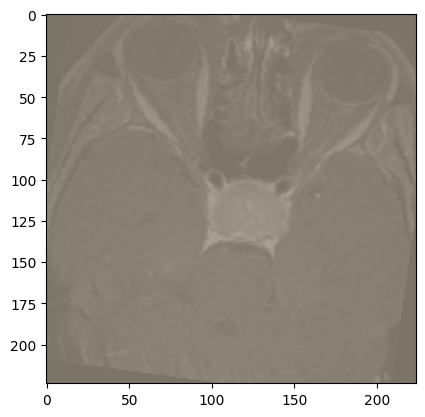

In [81]:
# Show an example image of croppedimages
dataiter = iter(data_loaders["train"])
images, labels = next(dataiter)

# Visualize the first image in the batch
imshow(images[0],)
plt.show()

Reusing cached mean and std


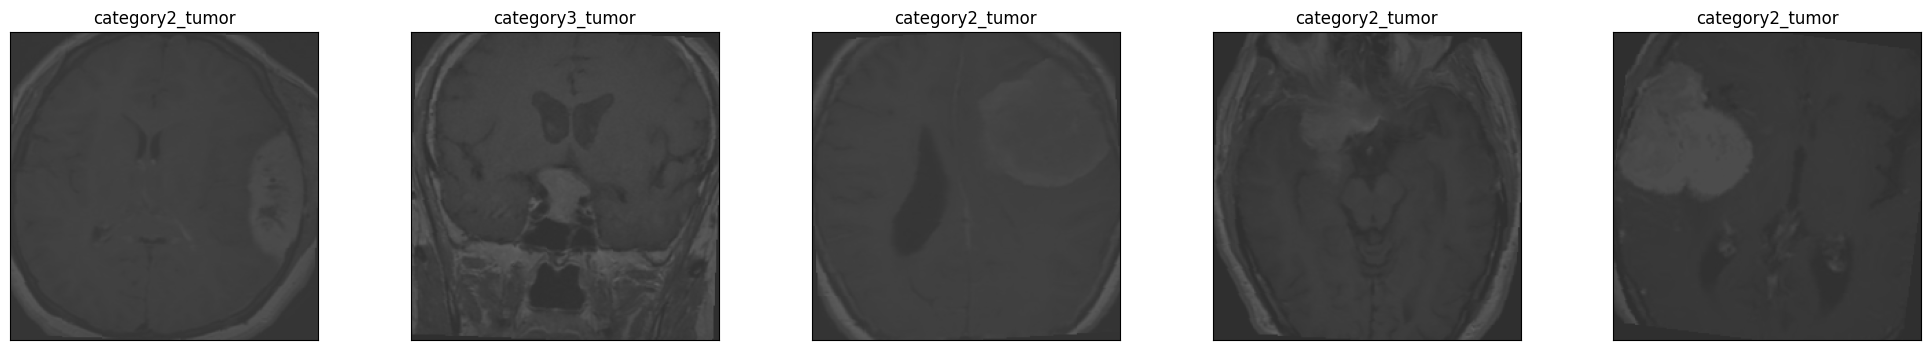

In [82]:
visualize_one_batch(data_loaders,"train")

In [37]:
model = BrainTumorClassifier(num_classes=num_classes,dropout=dropout)

optimizer =get_optimizer(model=model,optimizer=opt,learning_rate=learning_rate,weight_decay=weight_decay)

In [84]:
# Create a folder to store save the model
os.makedirs("checkpoints", exist_ok=True)

In [36]:
# Get the loss using get_loss
loss = get_loss()

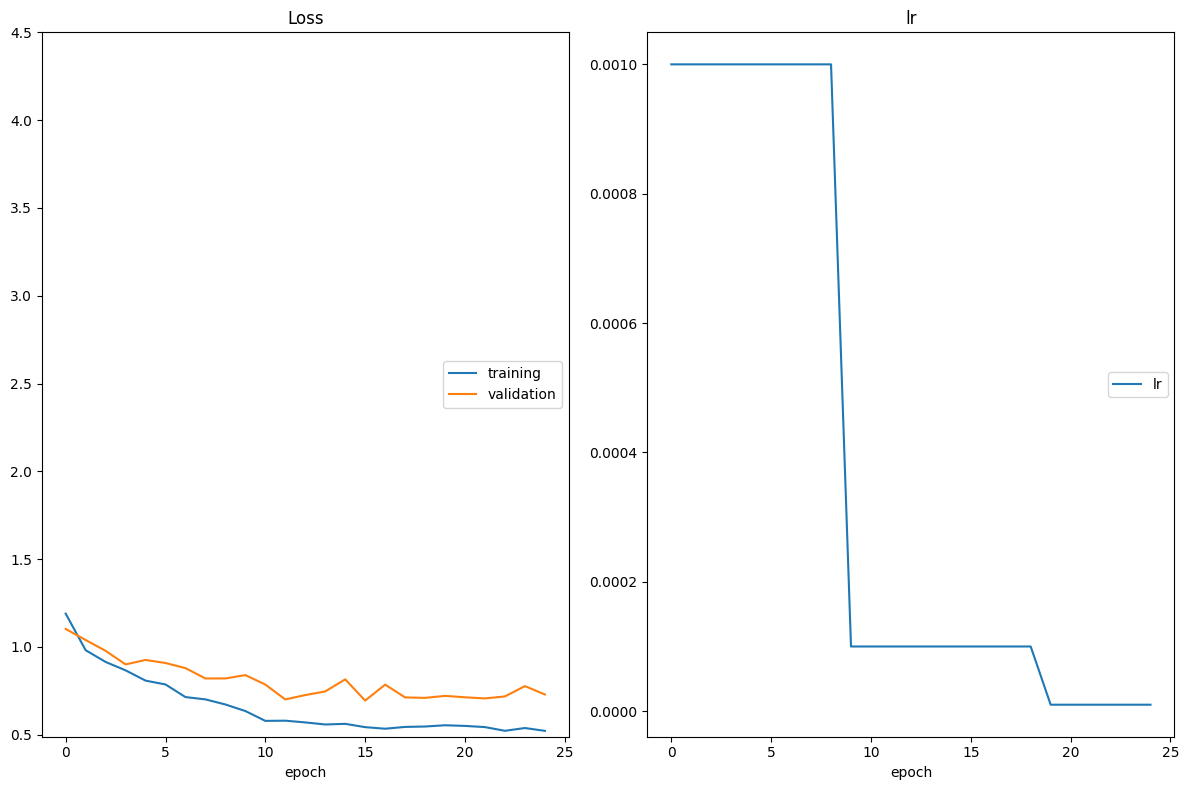

In [86]:

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

## Test the model


In [39]:
one_test_epoch(data_loaders["test"], model, loss)

Testing: 100%|██████████████████████████████████| 16/16 [01:42<00:00,  6.40s/it]

Test Loss: 0.433826


Test Accuracy: 85% (414/485)


0.433826420456171

## Save the model in .h5 format

In [40]:
data_loaders = get_data_loaders(batch_size=1)

Reusing cached mean and std
Dataset mean: tensor([0.1870, 0.1870, 0.1870]), std: tensor([0.1881, 0.1881, 0.1881])


In [89]:
class_names = data_loaders["train"].dataset.classes
class_names

['category1_tumor', 'category2_tumor', 'category3_tumor', 'no_tumor']

In [90]:
num_classes = len(class_names)
dropout_ = 0.5

In [91]:
# Move model to CPU for inference
model = BrainTumorClassifier(num_classes= num_classes, dropout = dropout_).cpu()

In [ ]:
# get the final best value loss pt
model.load_state_dict(torch.load("checkpoints/best_val_loss.pt",map_location = "cpu"))

In [93]:
mean, std = compute_mean_and_std()

Reusing cached mean and std


In [94]:
predictor = Predictor(model, class_names, mean, std).cpu()

In [95]:
torch.save(model, "BrainTumorClassifierModel.h5")

## Load the model

In [38]:
# Load the model from the file
model = torch.load("BrainTumorClassifierModel.h5")

In [20]:
# Print the model's state_dict
print(model.state_dict())

OrderedDict([('conv1.weight', tensor([[[[-1.7723e-01, -1.3675e-02, -1.6149e-02],
          [-4.5546e-02, -1.0565e-01, -1.5033e-01],
          [ 1.6438e-01, -8.5908e-02,  1.2203e-01]],

         [[-9.3772e-02, -3.3062e-02, -1.0556e-01],
          [ 1.0514e-01,  1.2473e-01,  1.9035e-01],
          [-3.4204e-02,  1.6930e-01, -2.2164e-02]],

         [[ 8.9629e-03,  1.1499e-01,  7.4458e-02],
          [ 5.5585e-02,  9.1433e-02, -3.3160e-02],
          [ 3.9689e-02, -1.0954e-01, -1.6338e-01]]],


        [[[ 5.4954e-02,  6.4876e-03,  1.0973e-01],
          [ 1.8959e-01, -8.1264e-02, -1.6426e-01],
          [ 1.2248e-01,  6.4485e-02, -5.6006e-03]],

         [[-1.9548e-01, -8.3979e-02,  6.2478e-02],
          [ 1.0689e-01,  5.7839e-02,  1.3957e-01],
          [ 1.8077e-01, -1.4471e-01, -9.9455e-02]],

         [[ 1.8779e-02,  1.3562e-03,  7.4523e-02],
          [ 6.4384e-02, -7.4465e-02, -6.9504e-03],
          [-2.3702e-02,  1.2639e-01,  1.9078e-01]]],


        [[[-5.6809e-02,  3.2960e-04,

# model architecture


In [53]:
print(model)

BrainTumorClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4, bias=True)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
